# Bayesian Statistics With Baseball Data: Priors and Posteriors


Let’s review the general set up for Bayesian modeling. We have:

### $$P\left(\text{model}|\text{data}\right) = \frac{P\left(\text{data}|\text{model}\right)P\left(\text{model}\right)}{P(\text{data})} $$

This is the diachronic interpretation of Bayes' theorem.

It can also be written as:

### $$\text{posterior} \propto \text{likelihood} \times \text{prior}$$

Here, the posterior is an update of our prior belief given the data observed.

In [2]:
# Imports the libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import pymc3 as pm
from scipy.stats import beta


In [3]:
# Load the data
df = pd.read_csv('./data/career_hits.csv')
df.head()

,name,hits,at_bat,average
0,Hank Aaron,3771,12364,0.304998
1,Tommie Aaron,216,944,0.228814
2,Andy Abad,2,21,0.095238
3,John Abadie,11,49,0.224490
4,Ed Abbaticchio,772,3044,0.253614


### 1) Try to find the top and bottom three hitters according to their average.

What is wrong with using the average to find the three best and worst hitters?

In [4]:
# Find the top 3 batting averages
df.sort_values('average', ascending=False)[:3]

,name,hits,at_bat,average
5853,John Mohardt,1,1,1.0
9303,Al Wright,1,1,1.0
359,Jeff Banister,1,1,1.0


In [5]:
# Find the bottom 3 batting averages with descending order of the DataFrame 
df.sort_values('average')[:3]

,name,hits,at_bat,average
1494,Larry Ciaffone,0,5,0.0
7303,Jay Rogers,0,8,0.0
2552,Ferd Eunick,0,2,0.0


### 2) Set up a prior distribution to represent our belief about batting average.

[After doing a quick search online](https://www.google.com/search?q=average+batting+average+for+players+mlb&oq=average+batting+average+for+players+mlb&aqs=chrome..69i57j0.7373j0j4&sourceid=chrome&ie=UTF-8), it looks like the overall batting average for MLB baseball players is around 0.260 (not up-to-date, but we'll use 0.260 for the lab).

Let's make it simple and say that our prior belief is that, out of 100 at-bats, we’ve seen 26 hits. Set up a beta distribution with `alpha=26` and `beta=74` using a function you can import from `scipy.stats`. Plot it.

**Take a look at the beta distribution's mean and variance to justify to yourself that these hyperparamters make sense!**

This is our distribution of beliefs on the batting average (probability of hitting while at bat) for MLB players.

In [6]:
# Beta prior with mean and variance calculated by
# mean = alpha/(alpha + beta) and variance = alpha* beta/((alph+beta)^2)*(alpha + beta +1). The other methods we can use 
# mean and variance is calculated based on pymc3 besides the use of alpha and beta formula.
prior_mean = df.at_bat.mean()
prior_std = df.at_bat.var()
print (prior_mean, prior_std)

1280.1250397709196 3828140.9810753474


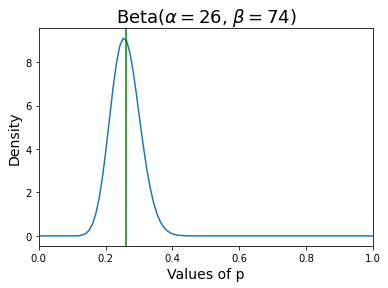

In [7]:
#Setting up alpha and beta as given above
a = 26
b = 74

# 0% of the beta distribution
lower = beta.ppf(0, a, b)

# 100% the beta distribution
upper = beta.ppf(1, a, b)

# combine lower and upper for the plot
x = np.linspace(lower, upper, 100)

plt.plot(x,
         beta(a,b).pdf(x))

# Plot batting 
plt.ylabel('Density', fontsize=14)
plt.xlim((lower,upper))
plt.xlabel('Values of p', fontsize=14)
plt.title(r'Beta($\alpha=26$, $\beta=74$)', fontsize=18)
plt.axvline(0.26, c='g');

### 3) Calculate the maximum a posteriori (MAP) estimate of each player's batting average.

The maximum a posteriori (MAP) estimate is the mode of a posterior distribution for a statistical parameter.

In our case, the MAP estimate for our players' batting averages will be the mode of the posterior beta distribution we get from updating our prior distribution with their at bats and hits.

---

> *Note: For an additional overview of the math behind updating the beta distribution posterior and conjugate priors, ([check out this website](https://alexanderetz.com/2015/07/25/understanding-bayes-updating-priors-via-the-likelihood/)).*

We need to update our beta distribution’s prior belief about batting averages with a player's at-bat and hit information to get a _new_ beta posterior distribution for that player's batting average. 

Luckily, with the beta distribution, the update is just a matter of adding in our new observations to the alpha and beta parameters, where alpha is the number of hits and beta is the number of misses/strikes:

    observed_hits = n_hits
    observed_misses = n_misses
    beta_prior = Beta(prior_hits, prior_misses)
    beta_posterior = Beta(prior_hits + observed_hits, prior_misses + observed_misses)
    
> **Note:** This process will also be useful in the context of A/B testing, which we’ll look at this week.

For each player, update the prior to the posterior distribution and calculate the mode of the distribution. The mode of a beta distribution is conveniently defined as:

### $$ \frac{\alpha - 1}{\alpha + \beta -2} $$

Which means we don't even need to use SciPy's beta distribution function. Just calculate the new alpha and beta for each player's posterior beta distribution (based on the formulas above the **Note**) and plug them into the formula directly above to get the MAP estimate of the batting average for each player.

In [8]:
# This is to estimate of MAP  of the batting average for each player 
XX = [] # for the modes of a posterior distribution    
for i in range(len(df)):
    a = 26   # alpha given above
    b = 74   # beta given above
    new_obs = (a+df.hits[i]-1)/((a+df.hits[i])+(b+df.at_bat[i] - df.hits[i])-2)  #new observations to the alpha and beta parameters
    XX.append(new_obs)
df['MAP'] = XX
df.head()

,name,hits,at_bat,average,MAP
0,Hank Aaron,3771,12364,0.304998,0.304606
1,Tommie Aaron,216,944,0.228814,0.231286
2,Andy Abad,2,21,0.095238,0.226891
3,John Abadie,11,49,0.224490,0.244898
4,Ed Abbaticchio,772,3044,0.253614,0.253660


### 4) Look up the top and bottom batters according to the MAP estimate.

In [9]:
#Looking up top batters of the estimated MAP 
df.sort_values('MAP', ascending=False)[:4]

,name,hits,at_bat,average,MAP
3938,Rogers Hornsby,2930,8173,0.358497,0.357272
4118,Shoeless Joe Jackson,1772,4981,0.355752,0.353810
2109,Ed Delahanty,2596,7505,0.345903,0.344732
3475,Billy Hamilton,2158,6268,0.344288,0.342915


In [10]:
#Looking up bottom batters of the estimated MAP 
df.sort_values('MAP')[:4]

,name,hits,at_bat,average,MAP
4322,Mike Jordan,12,125,0.096000,0.165919
4031,John Humphries,52,364,0.142857,0.166667
2987,Ed Gastfield,6,88,0.068182,0.166667
3113,Buck Gladmon,56,380,0.147368,0.169456


### 5) Plot the MLE batting average against the MAP batting average.
> Hint: What plot will also show the distribution of each (MLE And MAP)?

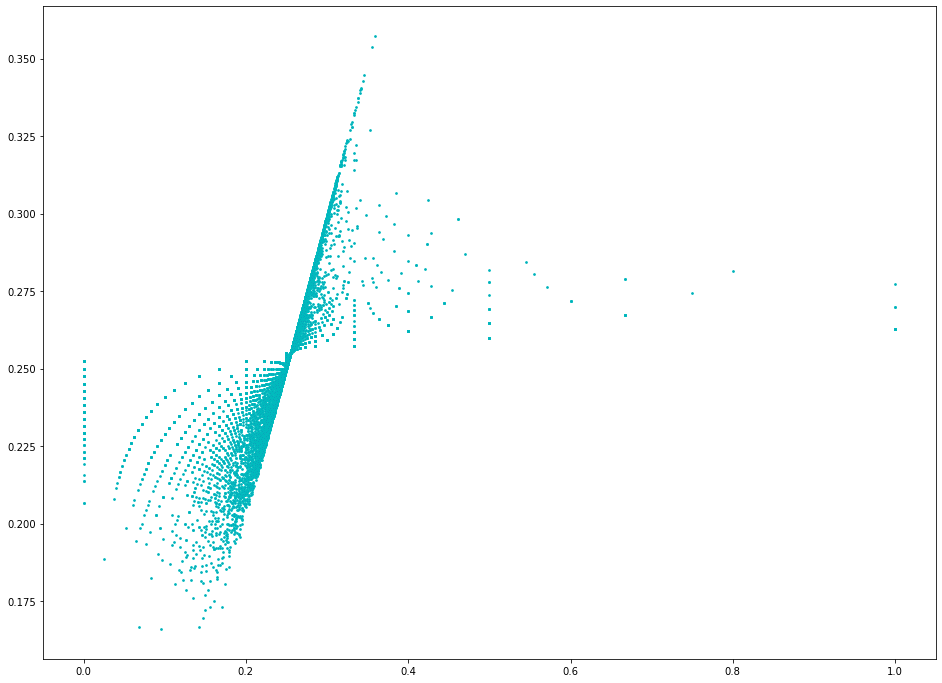

In [11]:
#  Plot the batting averages of  MLE vs MAP
plt.figure(figsize=(16,12))
plt.scatter(df.average, df.MAP, s=3, edgecolors='c');